## NIDS implementation using DL algorithms for NSL-KDD dataset

In [516]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Dropout,LSTM,Embedding,SimpleRNN, GRU,Activation,Flatten
from tensorflow.keras.layers import Conv1D,MaxPool1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import (precision_score, recall_score,confusion_matrix,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
import scikitplot as skplt
#import scikitplot as skplt

In [517]:
import tensorflow.keras
print('keras: %s' % tensorflow.keras.__version__)

keras: 2.2.4-tf


In [518]:

from pycaret.classification import *

In [520]:
train_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Train.csv'
test_url = 'https://raw.githubusercontent.com/merteroglu/NSL-KDD-Network-Instrusion-Detection/master/NSL_KDD_Test.csv'

In [521]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

In [522]:
ds_train=pd.read_csv(train_url,header=None, names = col_names)
ds_test=pd.read_csv(test_url, header=None, names = col_names)

In [523]:
ds=pd.concat([ds_train,ds_test], axis=0)

In [608]:
ds.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [524]:
ds.loc[(ds.label != 'normal'),'label']='attack'

In [525]:
ds.shape

(148517, 42)

## Feature engineering by pycaret

In [485]:
### dataset processed 
dsp_tr=setup(data = ds, sampling=False,
             target = 'label',train_size=0.85,
             numeric_imputation = 'mean',
             categorical_features = ['protocol_type','service','flag'], 
             normalize=True,normalize_method='minmax',
             feature_selection=True,feature_selection_threshold=0.2,
             silent = True)


 
Setup Succesfully Completed!


,Description,Value
0,session_id,5307
1,Target Type,Binary
2,Label Encoded,"attack: 0, normal: 1"
3,Original Data,"(148517, 42)"
4,Missing Values,False
5,Numeric Features,26
6,Categorical Features,15
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [526]:
X_train=dsp_tr[2]
X_test=dsp_tr[3]
y_train=dsp_tr[4]
y_test=dsp_tr[5]


In [527]:
trainX=np.array(X_train)
testT=np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [528]:
 X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
X_test = np.reshape(testT, (testT.shape[0], 1, testT.shape[1]))

# RNN(Recuurent Neural Networks)

### Simple RNN

In [511]:
batch_size = 32
id=dsp_tr[2].shape[1]
# 1. define the network
model_rnn = Sequential()
model_rnn.add(SimpleRNN(8,input_dim=id, return_sequences=True))  
model_rnn.add(Dropout(0.1))
model_rnn.add(SimpleRNN(8, return_sequences=False))  
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(1))
model_rnn.add(Activation('sigmoid'))

In [529]:

model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001,patience=5) ## early stoppoing 
Echeckpointer = callbacks.ModelCheckpoint(filepath="RNN-checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
#csv_logger = CSVLogger('training_set_iranalysis1.csv',separator=',', append=False)
model_rnn.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1000, validation_data=(X_test, y_test),callbacks=[es])
model_rnn.save("best_model_rnn.hdf5")

Train on 126239 samples, validate on 22278 samples
Epoch 1/1000
126239/126239 [==============================] - 20s 155us/sample - loss: 0.1125 - accuracy: 0.9561 - val_loss: 0.0981 - val_accuracy: 0.9591
Epoch 2/1000
126239/126239 [==============================] - 16s 126us/sample - loss: 0.1063 - accuracy: 0.9585 - val_loss: 0.0935 - val_accuracy: 0.9653
Epoch 3/1000
126239/126239 [==============================] - 16s 126us/sample - loss: 0.0998 - accuracy: 0.9607 - val_loss: 0.0875 - val_accuracy: 0.9649
Epoch 4/1000
126239/126239 [==============================] - 17s 131us/sample - loss: 0.0953 - accuracy: 0.9623 - val_loss: 0.0806 - val_accuracy: 0.9647
Epoch 5/1000
126239/126239 [==============================] - 18s 139us/sample - loss: 0.0920 - accuracy: 0.9634 - val_loss: 0.0793 - val_accuracy: 0.9688
Epoch 6/1000
126239/126239 [==============================] - 16s 130us/sample - loss: 0.0877 - accuracy: 0.9647 - val_loss: 0.0746 - val_accuracy: 0.9687
Epoch 7/1000
126239

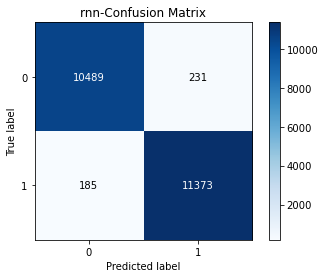

In [530]:

y_pred_rnn = model_rnn.predict_classes(X_test)
y_probs_rnn=model_rnn.predict_proba(X_test)
np.savetxt('rnn_predictions.txt', np.transpose(np.concatenate((y_test.reshape((y_test.size, 1)),y_pred_rnn), axis=1)), fmt='%01d')
np.savetxt('rnn_prob_predictions.txt', np.around(np.transpose(y_probs_rnn),decimals=5), fmt='%.5f')



######Plot confusion matrix




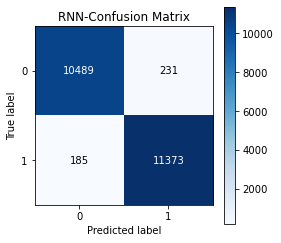

In [604]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rnn)
plt.title("RNN-Confusion Matrix")
plt.rcParams['figure.figsize']=(5,4)
plt.show()

In [531]:
accuracy = accuracy_score(y_test, y_pred_rnn)
print("accuracy:",accuracy)
f1score=f1_score(y_test, y_pred_rnn)
print("f1-acore:",f1score)
cm=confusion_matrix(y_test, y_pred_rnn)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred_rnn)
print("Precision:",pr)
rs=recall_score(y_test,y_pred_rnn)
print("Recall_score:",rs)

accuracy: 0.9813268695574109
f1-acore: 0.9820395475347551
confusion matrix:
 [[10489   231]
 [  185 11373]]
Precision: 0.9800930713547052
Recall_score: 0.9839937705485378


In [532]:
### evaluate/calculate metrics  from saved model 

# load a saved model
from tensorflow.keras.models import load_model
saved_model = load_model('lstm_model.hdf5')
loss,accur = saved_model.evaluate(X_test, y_test)
print("\n Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

22278/22278 [==============================] - 2s 87us/sample - loss: 0.0198 - accuracy: 0.9926

 Loss: 0.02, Accuracy: 98.13%


## LSTM 

In [533]:
id=dsp_tr[2].shape[1]
batch_size=32

In [534]:
model_lstm = Sequential()
#model_dnn3.add(Flatten())
model_lstm.add(LSTM(8,input_dim=id, return_sequences=True))  
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(8, return_sequences=False))  
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.add(Activation('sigmoid'))

In [535]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001,patience=5) ## early stoppoing


model_lstm.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1000, validation_data=(X_test, y_test),callbacks=[es])
model_lstm.save("lstm_model_lstm.hdf5")

Train on 126239 samples, validate on 22278 samples
Epoch 1/1000
126239/126239 [==============================] - 32s 252us/sample - loss: 0.1512 - accuracy: 0.9500 - val_loss: 0.0964 - val_accuracy: 0.9637
Epoch 2/1000
126239/126239 [==============================] - 24s 189us/sample - loss: 0.0916 - accuracy: 0.9643 - val_loss: 0.0787 - val_accuracy: 0.9688
Epoch 3/1000
126239/126239 [==============================] - 25s 195us/sample - loss: 0.0779 - accuracy: 0.9689 - val_loss: 0.0689 - val_accuracy: 0.9725
Epoch 4/1000
126239/126239 [==============================] - 26s 207us/sample - loss: 0.0693 - accuracy: 0.9722 - val_loss: 0.0631 - val_accuracy: 0.9759
Epoch 5/1000
126239/126239 [==============================] - 24s 194us/sample - loss: 0.0633 - accuracy: 0.9751 - val_loss: 0.0566 - val_accuracy: 0.9777
Epoch 6/1000
126239/126239 [==============================] - 25s 195us/sample - loss: 0.0583 - accuracy: 0.9774 - val_loss: 0.0525 - val_accuracy: 0.9813
Epoch 7/1000
126239

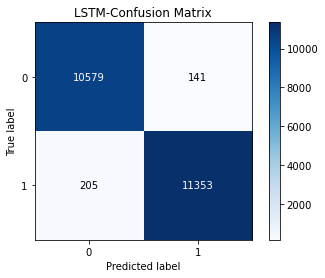

In [536]:

y_pred_lstm = model_lstm.predict_classes(X_test)
y_probs_lstm=model_lstm.predict_proba(X_test)
np.savetxt('lstm_predictions.txt', np.transpose(np.concatenate((y_test.reshape((y_test.size, 1)),y_pred_lstm), axis=1)), fmt='%01d')
np.savetxt('lstm_prob_predictions.txt', np.around(np.transpose(y_probs_lstm),decimals=5), fmt='%.5f')


######Plot confusion matrix

skplt.metrics.plot_confusion_matrix(y_test, y_pred_lstm)
plt.title("LSTM-Confusion Matrix")
plt.show()

In [537]:
### evaluate/calculate metrics  from saved model 

# load a saved model
from tensorflow.keras.models import load_model
saved_model = load_model('lstm_model.hdf5')
loss,accur = saved_model.evaluate(X_test, y_test)
print("\n Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

22278/22278 [==============================] - 2s 85us/sample - loss: 0.0198 - accuracy: 0.9926

 Loss: 0.02, Accuracy: 98.13%


In [539]:
accuracy = accuracy_score(y_test, y_pred_lstm)
print("accuracy:",accuracy)
f1score=f1_score(y_test, y_pred_lstm)
print("f1-acore:",f1score)
cm=confusion_matrix(y_test, y_pred_lstm)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred_lstm)
print("Precision:",pr)
rs=recall_score(y_test,y_pred_lstm)
print("Recall_score:",rs)
#misclassified_samples = X_test[y_test != y_pred_lstm]
#mc=misclassified_samples.shape[0]
#print("Misclassified :",mc)

accuracy: 0.9844689828530389
f1-acore: 0.984990456359535
confusion matrix:
 [[10579   141]
 [  205 11353]]
Precision: 0.9877327301200627
Recall_score: 0.982263367364596


## GRU 

In [540]:
batch_size = 64
id=dsp_tr[2].shape[1] 

In [541]:
model_gru = Sequential()
#model_gru.add(Flatten())
model_gru.add(GRU(32,input_dim=id, return_sequences=True))  
model_gru.add(Dropout(0.1))
model_gru.add(GRU(32, return_sequences=True))  
model_gru.add(Dropout(0.1))
model_gru.add(GRU(32, return_sequences=True))  
model_gru.add(Dropout(0.1))
model_gru.add(GRU(32, return_sequences=False))  
model_gru.add(Dropout(0.1))
#model_gru.add(Flatten())
model_gru.add(Dense(1))
model_gru.add(Activation('sigmoid'))


In [542]:
# try using different optimizers and different optimizer configs

model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001,patience=5) ## early stoppoing

model_gru.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=batch_size, epochs=1000, callbacks=[es])
model_gru.save("model_gru.hdf5")

Train on 126239 samples, validate on 22278 samples
Epoch 1/1000
126239/126239 [==============================] - 35s 279us/sample - loss: 0.1303 - accuracy: 0.9505 - val_loss: 0.0873 - val_accuracy: 0.9631
Epoch 2/1000
126239/126239 [==============================] - 22s 173us/sample - loss: 0.0820 - accuracy: 0.9666 - val_loss: 0.0727 - val_accuracy: 0.9707
Epoch 3/1000
126239/126239 [==============================] - 23s 181us/sample - loss: 0.0674 - accuracy: 0.9728 - val_loss: 0.0587 - val_accuracy: 0.9787
Epoch 4/1000
126239/126239 [==============================] - 23s 181us/sample - loss: 0.0584 - accuracy: 0.9769 - val_loss: 0.0531 - val_accuracy: 0.9804
Epoch 5/1000
126239/126239 [==============================] - 22s 176us/sample - loss: 0.0542 - accuracy: 0.9788 - val_loss: 0.0504 - val_accuracy: 0.9819
Epoch 6/1000
126239/126239 [==============================] - 22s 177us/sample - loss: 0.0517 - accuracy: 0.9798 - val_loss: 0.0478 - val_accuracy: 0.9832
Epoch 7/1000
126239

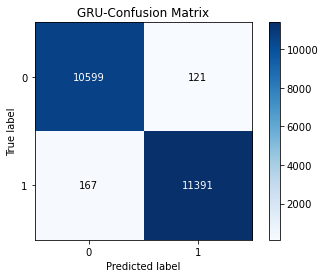

In [543]:

y_pred_gru = model_gru.predict_classes(X_test)
y_probs_gru=model_gru.predict_proba(X_test)
np.savetxt('gru_predictions.txt', np.transpose(np.concatenate((y_test.reshape((y_test.size, 1)),y_pred_gru), axis=1)), fmt='%01d')
np.savetxt('gru_prob_predictions.txt', np.around(np.transpose(y_probs_gru),decimals=5), fmt='%.5f')




######Plot confusion matrix

skplt.metrics.plot_confusion_matrix(y_test, y_pred_gru)
plt.title("GRU-Confusion Matrix")
plt.show()

In [544]:
accuracy = accuracy_score(y_test, y_pred_gru)
print("accuracy:",accuracy)
f1score=f1_score(y_test, y_pred_gru)
print("f1-acore:",f1score)
cm=confusion_matrix(y_test, y_pred_gru)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred_gru)
print("Precision:",pr)
rs=recall_score(y_test,y_pred_gru)
print("Recall_score:",rs)


accuracy: 0.9870724481551306
f1-acore: 0.987516254876463
confusion matrix:
 [[10599   121]
 [  167 11391]]
Precision: 0.9894892286309938
Recall_score: 0.9855511334140855


# Deep Neural networks

### 3 layers

In [559]:
batch_size = 64
id=dsp_tr[2].shape[1] 
# define network
model_dnn3 = Sequential()
model_dnn3.add(Flatten())
model_dnn3.add(Dense(1024,input_dim=id,activation='relu'))  
model_dnn3.add(Dropout(0.01))
model_dnn3.add(Dense(768,activation='relu'))  
model_dnn3.add(Dropout(0.01))

model_dnn3.add(Dense(1))
model_dnn3.add(Activation('sigmoid'))



In [560]:
# try using different optimizers and different optimizer configs

model_dnn3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001,patience=5) ## early stoppoing

model_dnn3.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=batch_size, epochs=1000, callbacks=[es])
model_dnn3.save("dnn_two_layer_model_dnn3.hdf5")

Train on 126239 samples, validate on 22278 samples
Epoch 1/1000
126239/126239 [==============================] - 37s 291us/sample - loss: 0.0678 - accuracy: 0.9736 - val_loss: 0.0470 - val_accuracy: 0.9832
Epoch 2/1000
126239/126239 [==============================] - 32s 255us/sample - loss: 0.0421 - accuracy: 0.9836 - val_loss: 0.0418 - val_accuracy: 0.9847
Epoch 3/1000
126239/126239 [==============================] - 31s 242us/sample - loss: 0.0371 - accuracy: 0.9856 - val_loss: 0.0347 - val_accuracy: 0.9880
Epoch 4/1000
126239/126239 [==============================] - 33s 261us/sample - loss: 0.0335 - accuracy: 0.9868 - val_loss: 0.0354 - val_accuracy: 0.9862
Epoch 5/1000
126239/126239 [==============================] - 35s 277us/sample - loss: 0.0313 - accuracy: 0.9881 - val_loss: 0.0376 - val_accuracy: 0.9863
Epoch 6/1000
126239/126239 [==============================] - 32s 252us/sample - loss: 0.0292 - accuracy: 0.9885 - val_loss: 0.0339 - val_accuracy: 0.9865
Epoch 7/1000
126239

In [594]:
y_pred_dnn3 = model_dnn3.predict_classes(X_test)
y_probs_dnn3=model_dnn3.predict_proba(X_test)
np.savetxt('dnn3_predictions.txt', np.transpose(np.concatenate((y_test.reshape((y_test.size, 1)),y_pred_dnn3), axis=1)), fmt='%01d')
np.savetxt('dnn3_prob_predictions.txt', np.around(np.transpose(y_probs_dnn3),decimals=5), fmt='%.5f')






In [562]:
accuracy = accuracy_score(y_test, y_pred=y_pred_dnn3)
print("accuracy:",accuracy)
f1score=f1_score(y_test, y_pred=y_pred_dnn3)
print("f1-acore:",f1score)
cm=confusion_matrix(y_test, y_pred=y_pred_dnn3)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred=y_pred_dnn3)
print("Precision:",pr)
rs=recall_score(y_test,y_pred=y_pred_dnn3)
print("Recall_score:",rs)

accuracy: 0.9894065894604542
f1-acore: 0.9897932704783323
confusion matrix:
 [[10599   121]
 [  115 11443]]
Precision: 0.9895364925631269
Recall_score: 0.9900501816923343


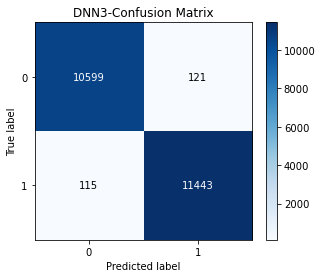

In [593]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_dnn3)
plt.title("DNN3-Confusion Matrix")
plt.rcParams['figure.figsize']=(5,4)
plt.show()

### DNN 4 layers

In [563]:
batch_size = 64
id=dsp_tr[2].shape[1]
model_dnn4 = Sequential()
model_dnn4.add(Flatten())
model_dnn4.add(Dense(1024,input_dim=id,activation='relu'))  
model_dnn4.add(Dropout(0.01))
model_dnn4.add(Dense(768,activation='relu'))  
model_dnn4.add(Dropout(0.01))
model_dnn4.add(Dense(512,activation='relu'))  
model_dnn4.add(Dropout(0.01))
model_dnn4.add(Dense(256,activation='relu'))  
model_dnn4.add(Dropout(0.01))
model_dnn4.add(Dense(1))
model_dnn4.add(Activation('sigmoid'))

In [ ]:
model_dnn4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001,patience=5) ## early stoppoing

model_dnn4.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=batch_size, epochs=1000, callbacks=[es])
#model_dnn4.save("dnn4layer_model.hdf5")


Train on 126239 samples, validate on 22278 samples
Epoch 1/1000
126239/126239 [==============================] - 64s 503us/sample - loss: 0.0213 - accuracy: 0.9920 - val_loss: 0.0360 - val_accuracy: 0.9883
Epoch 2/1000
115328/126239 [==========================>...] - ETA: 4s - loss: 0.0191 - accuracy: 0.9924

In [592]:
y_pred_dnn4 = model_dnn4.predict_classes(X_test)
y_probs_dnn4=model_dnn4.predict_proba(X_test)
np.savetxt('dnn4_predictions.txt', np.transpose(np.concatenate((y_test.reshape((y_test.size, 1)),y_pred_dnn4), axis=1)), fmt='%01d')
np.savetxt('dnn4_prob_predictions.txt', np.around(np.transpose(y_probs_dnn4),decimals=5), fmt='%.5f')



In [566]:
accuracy = accuracy_score(y_test, y_pred_dnn4)
print("accuracy:",accuracy)
f1score=f1_score(y_test, y_pred_dnn4)
print("f1-acore:",f1score)
cm=confusion_matrix(y_test, y_pred_dnn4)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred_dnn4)
print("Precision:",pr)
rs=recall_score(y_test,y_pred_dnn4)
print("Recall_score:",rs)

accuracy: 0.9891821527964808
f1-acore: 0.9895548909981363
confusion matrix:
 [[10621    99]
 [  142 11416]]
Precision: 0.9914025184541901
Recall_score: 0.9877141373940128


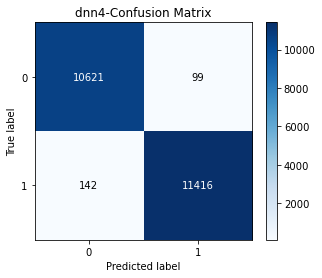

In [591]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_dnn4)
plt.title("dnn4-Confusion Matrix")
plt.rcParams['figure.figsize']=(5,4)
plt.show()

#  Convolutional Neural Networks

In [567]:
import tensorflow.keras
print('keras: %s' % tensorflow.keras.__version__)

keras: 2.2.4-tf


In [576]:
X_train=dsp_tr[2]
X_test=dsp_tr[3]
y_train=dsp_tr[4]
y_test=dsp_tr[5]
trainX=np.array(X_train)
testT=np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [577]:
X_train = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
X_test = np.reshape(testT, (testT.shape[0],testT.shape[1],1))

In [578]:
#lstm_output_size = 128

model_cnn = Sequential()
model_cnn.add(Conv1D(64, 3, padding="same",activation="relu",input_shape=(id, 1)))
model_cnn.add(Conv1D(64, 3, padding="same", activation="relu"))
model_cnn.add(MaxPool1D(pool_size=(2)))
model_cnn.add(Conv1D(128, 3, padding="same", activation="relu"))
model_cnn.add(Conv1D(128, 3, padding="same", activation="relu"))
model_cnn.add(MaxPool1D(pool_size=(2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation="sigmoid"))

In [579]:
model_cnn.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0001,patience=5) ## early stoppoing


model_cnn.fit(X_train, y_train, epochs=1000,validation_data=(X_test, y_test),callbacks=[es])
model_cnn.save("model_cnn_model.hdf5")

Train on 126239 samples, validate on 22278 samples
Epoch 1/1000
126239/126239 [==============================] - 104s 822us/sample - loss: 0.0747 - accuracy: 0.9711 - val_loss: 0.0453 - val_accuracy: 0.9843
Epoch 2/1000
126239/126239 [==============================] - 105s 833us/sample - loss: 0.0434 - accuracy: 0.9846 - val_loss: 0.0395 - val_accuracy: 0.9864
Epoch 3/1000
126239/126239 [==============================] - 95s 750us/sample - loss: 0.0378 - accuracy: 0.9866 - val_loss: 0.0338 - val_accuracy: 0.9877
Epoch 4/1000
126239/126239 [==============================] - 86s 683us/sample - loss: 0.0331 - accuracy: 0.9882 - val_loss: 0.0330 - val_accuracy: 0.9893
Epoch 5/1000
126239/126239 [==============================] - 92s 727us/sample - loss: 0.0309 - accuracy: 0.9892 - val_loss: 0.0323 - val_accuracy: 0.9890
Epoch 6/1000
126239/126239 [==============================] - 92s 727us/sample - loss: 0.0284 - accuracy: 0.9902 - val_loss: 0.0327 - val_accuracy: 0.9886
Epoch 7/1000
1262

In [590]:
y_pred_cnn = model_cnn.predict_classes(X_test)
y_probs_cnn=model_cnn.predict_proba(X_test)
np.savetxt('cnn_predictions.txt', np.transpose(np.concatenate((y_test.reshape((y_test.size, 1)),y_pred_cnn), axis=1)), fmt='%01d')
np.savetxt('cnn_prob_predictions.txt', np.around(np.transpose(y_probs_cnn),decimals=5), fmt='%.5f')


######Plot confusion matrix

# skplt.metrics.plot_confusion_matrix(y_test, y_pred_cnn)
# plt.title("CNN-Confusion Matrix")
# plt.show()

In [583]:
accuracy = accuracy_score(y_test, y_pred_cnn)
print("accuracy:",accuracy)
f1score=f1_score(y_test, y_pred_cnn)
print("f1-acore:",f1score)
cm=confusion_matrix(y_test, y_pred_cnn)
print("confusion matrix:\n",cm)
pr=precision_score(y_test,y_pred_cnn)
print("Precision:",pr)
rs=recall_score(y_test,y_pred_cnn)
print("Recall_score:",rs)

accuracy: 0.9915611814345991
f1-acore: 0.9918818550824768
confusion matrix:
 [[10605   115]
 [   73 11485]]
Precision: 0.9900862068965517
Recall_score: 0.9936840283786122


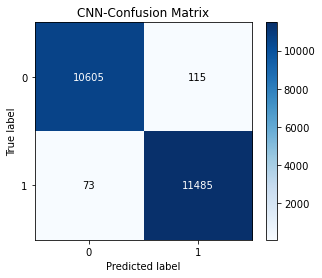

In [589]:

skplt.metrics.plot_confusion_matrix(y_test, y_pred_cnn)
plt.title("CNN-Confusion Matrix")
plt.rcParams['figure.figsize']=(5,4)
plt.show()

## ROC Curves

In [ ]:
##################ROC curve

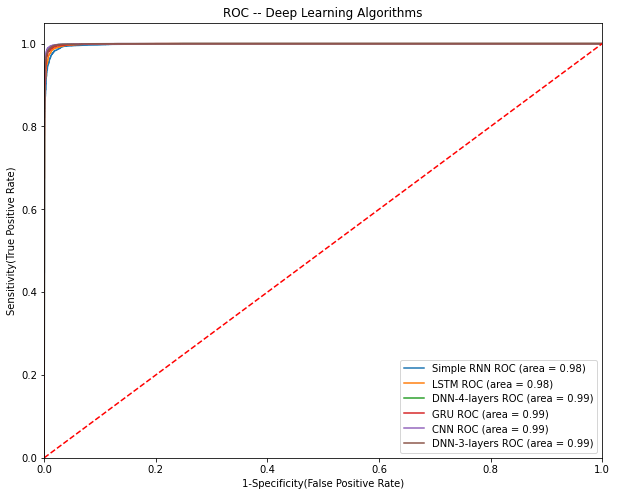

In [599]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Simple RNN',
    'pred': y_pred_rnn,
    'model': model_rnn,
    'prob':y_probs_rnn
},
{
    'label': 'LSTM',
    'pred': y_pred_lstm,
    'model': model_lstm,
    'prob':y_probs_lstm
    
},
    {
    'label': 'DNN-4-layers',
    'pred': y_pred_dnn4,
    'model':model_dnn4,
    'prob' :y_probs_dnn4
        
},
    {
    'label': 'GRU',
    'pred': y_pred_gru,
    'model': model_gru,
    'prob':y_probs_gru
},
    {
    'label': 'CNN',
    'pred': y_pred_cnn,
    'model': model_cnn,
    'prob':y_probs_cnn
},
 {
    'label': 'DNN-3-layers',
    'pred': y_pred_dnn3,
    'model': model_dnn3,
     'prob':y_probs_dnn3
},
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    #model.fit(X_train, y_train) # train the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    #fpr, tpr, thresholds =  roc_curve(y_test, model.predict_proba(X_test)[:,1])
    fpr, tpr, thresholds =  roc_curve(y_test, m['prob'])
# Calculate Area under the curve to display on the plot
    auc =  roc_auc_score(y_test,m['pred'])
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('ROC -- Deep Learning Algorithms')
plt.legend(loc="lower right")
plt.rcParams['figure.figsize']=(16,8)
plt.show()   # Display


In [ ]:
y_probs